<a href="https://colab.research.google.com/github/jeffveleze/age-gender-recognizer/blob/master/AgeGenderRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0

In [0]:
# Helper libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import PIL

from PIL import Image
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import metrics

# Sklean
from sklearn.model_selection import train_test_split

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# Define paths
base_dir = 'drive/My Drive/Age-Gender-Recognizer-Dataset/'
number_dir = '00'
files_extension = '.jpg'

# Create local data path object
local_data_path = base_dir + number_dir + '/*' + files_extension
local_data_path = os.path.expanduser(local_data_path)

# Create array with image addresses
image_addresses = glob.glob(local_data_path)
base_path = base_dir + number_dir + '/'

# Create function to extract data
def make_lists(address):
  name_file = address.replace(base_path,'')
  name_components = name_file.split('_')

  image_id = name_components[0]
  birth_date = name_components[1]
  publish_date = name_components[2].replace(files_extension, '')

  birth_date_year = int(birth_date.split('-')[0])
  publish_date_year = int(publish_date)
  age = publish_date_year - birth_date_year

  return (image_id, birth_date, birth_date_year, publish_date_year, age)

# Create initial values
RESIZED_WIDTH = 200
RESIZED_HEIGHT = 200
addresses = []
image_ids = []
birth_dates = []
birth_date_years = []
publish_date_years = []
ages = []
image_matrixes = []

for address in image_addresses:
  image_id, birth_date, birth_date_year, publish_date_year, age = make_lists(address)

  if age > 0 and age < 100:

    # Appending path taken values
    addresses.append(address)
    image_ids.append(image_id)
    birth_dates.append(birth_date)
    birth_date_years.append(birth_date_year)
    publish_date_years.append(publish_date_year)
    ages.append(age)

    # Transforming images into matrixes and applying resizing
    image = Image.open(address)
    image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
    image_matrix = np.asarray(image.convert('RGB'))

    # Normalizing image_matrix
    image_matrix = image_matrix / 255

    # Adding image to list
    image_matrixes.append(image_matrix)

np.array(image_matrixes).shape

(571, 200, 200, 3)

In [6]:
# Create dictionary arrays
images_dictionary = {'image_matrix' : image_matrixes, 'age' : ages}
images_data_frame = pd.DataFrame(images_dictionary)

# Visualize dataframe
images_data_frame.head()

,image_matrix,age
0,"[[[0.6745098039215687, 0.5725490196078431, 0.4...",48
1,"[[[0.23921568627450981, 0.25098039215686274, 0...",24
2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",56
3,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",32
4,"[[[0.28627450980392155, 0.3176470588235294, 0....",24


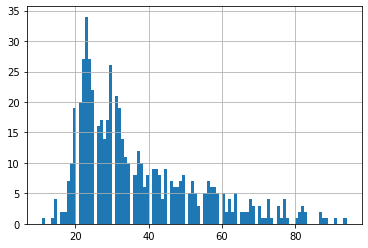

In [0]:
images_data_frame['age'].hist(bins=100)            

In [0]:
images_data_frame.describe()

,age
count,571.000000
mean,36.924694
std,16.458228
min,11.000000
25%,24.000000
50%,31.000000
75%,46.000000
max,94.000000


In [15]:
# Separating X and Y columns
X_df = images_data_frame['image_matrix'].copy()
Y_df = images_data_frame['age'].copy()

# Transform train and test data to be a np.array instead of pd.series
X_df = np.stack(X_df, axis=0)
Y_df = np.stack(Y_df, axis=0)

# Splitting train and test data
train_images, test_images, train_labels, test_labels = train_test_split(X_df, 
                                                                        Y_df, 
                                                                        test_size = 0.2, 
                                                                        random_state = 2)

# Verifying correct shape
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(456, 200, 200, 3)
(115, 200, 200, 3)
(456,)
(115,)


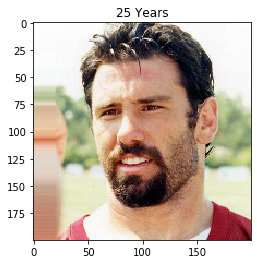

In [16]:
# Drawing train_images[image_index]
image_index = 10
plt.figure()
plt.title(str(train_labels[image_index]) + " Years")
plt.imshow(train_images[image_index], cmap = plt.cm.binary)
plt.grid(False)
plt.show()

In [0]:
# Adding function to create functional model
def make_functional_model(hyperparams):

  inputs = tf.keras.Input(shape=(RESIZED_WIDTH, RESIZED_HEIGHT, 3))
  x1 = tf.keras.layers.Flatten()(inputs)
  x = x1

  units = hyperparams['units']
  
  # Inserting new layers 
  while units >= 8:
    x = tf.keras.layers.Dense(units, activation = hyperparams['activation'])(x)
    # x = tf.keras.layers.Dropout(hyperparams['dropout'])(x)
    units /= 2

  x2 = tf.keras.layers.Dense(32)(x1)
  x = tf.keras.layers.Concatenate()([x, x2])
  outputs = tf.keras.layers.Dense(1)(x)

  functional_model = tf.keras.Model(inputs = inputs, outputs = outputs)
  
  return functional_model

In [0]:
# Adding function to create sequential model
def make_sequential_model(hyperparams):

  layers_list = []
  layers_list.append(tf.keras.layers.Flatten(input_shape=(RESIZED_WIDTH, RESIZED_HEIGHT, 3)))

  units = hyperparams['units']
  
  # Inserting new layers 
  while units >= 8:
    new_layer = tf.keras.layers.Dense(units, activation = hyperparams['activation'])
    layers_list.append(new_layer)
    units /= 2

  # No activation function is used for the output layer because it's a 
  # regression problem and we are interested in predicting numerical values 
  # directly without transform.
  layers_list.append(tf.keras.layers.Dense(1))
  sequential_model = tf.keras.models.Sequential(layers_list)

  return sequential_model

In [0]:
# Defining hyperparameters
hyperparams = {'dense' : 4, 
               'units': 256, 
               'activation' : 'relu', 
               'dropout': 0.3}

# Creating models
functional_model = make_functional_model(hyperparams)
sequential_model = make_sequential_model(hyperparams)

# Compiling models
functional_model.compile(optimizer = 'adam',
                         loss = 'mse',
                         metrics = ['mae'])

sequential_model.compile(optimizer = 'adam',
                         loss = 'mse',
                         metrics = ['mae'])

In [0]:
functional_model.summary()

In [259]:
# Train model and save functional model history
fm_history = functional_model.fit(x = train_images, 
                                  y = train_labels, 
                                  batch_size = 16, 
                                  epochs = 50, 
                                  validation_split = 0.15)

Train on 387 samples, validate on 69 samples
Epoch 1/100
387/387 [==============================] - 3s 9ms/sample - loss: 11642.7682 - mae: 81.7248 - val_loss: 3214.0925 - val_mae: 51.9702
Epoch 2/100
387/387 [==============================] - 3s 7ms/sample - loss: 1166.9522 - mae: 27.2667 - val_loss: 557.2514 - val_mae: 20.0217
Epoch 3/100
387/387 [==============================] - 3s 7ms/sample - loss: 532.3687 - mae: 17.7929 - val_loss: 430.7357 - val_mae: 16.3982
Epoch 4/100
387/387 [==============================] - 3s 7ms/sample - loss: 455.3439 - mae: 16.3665 - val_loss: 650.9742 - val_mae: 21.3739
Epoch 5/100
387/387 [==============================] - 3s 7ms/sample - loss: 495.6821 - mae: 17.5078 - val_loss: 731.8700 - val_mae: 22.6964
Epoch 6/100
387/387 [==============================] - 3s 7ms/sample - loss: 500.8513 - mae: 17.5328 - val_loss: 389.8331 - val_mae: 15.8581
Epoch 7/100
387/387 [==============================] - 3s 7ms/sample - loss: 368.4750 - mae: 14.3698 - va

In [260]:
# Print resulting functional_model metrics
test_mse_fm, test_mae_fm = functional_model.evaluate(x = test_images, 
                                                     y = test_labels, 
                                                     batch_size = 16)

print("Test MSE Functional Model: {}".format(test_mse_fm))
print("Test MAE Functional Model: {}".format(test_mae_fm))

115/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [261]:
sequential_model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_61 (Flatten)         (None, 120000)            0         
_________________________________________________________________
dense_3400 (Dense)           (None, 256)               30720256  
_________________________________________________________________
dense_3401 (Dense)           (None, 128)               32896     
_________________________________________________________________
dense_3402 (Dense)           (None, 64)                8256      
_________________________________________________________________
dense_3403 (Dense)           (None, 32)                2080      
_________________________________________________________________
dense_3404 (Dense)           (None, 16)                528       
_________________________________________________________________
dense_3405 (Dense)           (None, 8)               

In [262]:
# Train model and save functional model history
sm_history = sequential_model.fit(x = train_images, 
                                  y = train_labels, 
                                  batch_size = 16, 
                                  epochs = 100, 
                                  validation_split = 0.15)

Train on 387 samples, validate on 69 samples
Epoch 1/100
387/387 [==============================] - 3s 8ms/sample - loss: 621.0203 - mae: 19.4004 - val_loss: 568.6547 - val_mae: 18.3666
Epoch 2/100
387/387 [==============================] - 2s 6ms/sample - loss: 559.6874 - mae: 18.5188 - val_loss: 502.3643 - val_mae: 19.1675
Epoch 3/100
387/387 [==============================] - 2s 6ms/sample - loss: 490.5515 - mae: 17.0354 - val_loss: 388.5581 - val_mae: 15.4824
Epoch 4/100
387/387 [==============================] - 2s 6ms/sample - loss: 414.9777 - mae: 15.7291 - val_loss: 426.3330 - val_mae: 15.8934
Epoch 5/100
387/387 [==============================] - 2s 6ms/sample - loss: 403.2540 - mae: 15.5138 - val_loss: 580.7268 - val_mae: 20.5343
Epoch 6/100
387/387 [==============================] - 2s 6ms/sample - loss: 371.1716 - mae: 14.7337 - val_loss: 428.5696 - val_mae: 16.9781
Epoch 7/100
387/387 [==============================] - 2s 6ms/sample - loss: 299.6934 - mae: 13.1444 - val_lo

In [263]:
# Print resulting sequential_model metrics
test_mse_sm, test_mae_sm = sequential_model.evaluate(x = test_images, 
                                                     y = test_labels, 
                                                     batch_size = 16)

print("Test MSE Sequential Model: {}".format(test_mse_sm))
print("Test MAE Sequential Model: {}".format(test_mae_sm))

115/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [240]:
# Predict with test images
predictions = sequential_model.predict(x = test_images)

print(predictions.shape)

(115, 1)


In [249]:
# Evaluating
test_index = 3
correct_age = test_labels[test_index]
predicted_age = predictions[test_index][0]

# Print results
print(correct_age)
print(predicted_age)

21
50.42005


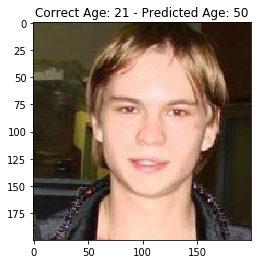

In [250]:
# Validating co-relation between image and real/predicted age
plt.figure()
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(test_images[test_index], cmap = plt.cm.binary)
plt.grid(False)
plt.show()